In [1]:
import sys

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import importlib
from scipy.io import FortranFile

import time 
import cftime 

import RegridField as RgF

# import modules in other directories
sys.path.append('../Utils/')
import GridUtils as GrU
import MakePressures as MkP
import humiditycalcs as hum
import MyConstants as Con

sys.path.append('../Regridder/')
import Initialize as Prep
import ReadInSrc as RdSrc
import WriteDST as WrDst
import GenRegrid as GR
import latlon_w_scrip as LL
import var_A_x_B as AxB


importlib.reload( RgF )
importlib.reload( AxB )
importlib.reload( LL )
importlib.reload( GR )
importlib.reload( Prep )
importlib.reload( RdSrc )
importlib.reload( WrDst )


 a path added in VertRegridFlexLL /glade/work/juliob/PyRegridding/Regridder/../Utils 
 MyConstants in /glade/work/juliob/PyRegridding/Utils 
Using Flexible parallel/serial VertRegrid 
 a path added in VertRegridFlexLL /glade/work/juliob/PyRegridding/Regridder/../Utils 
 MyConstants in /glade/work/juliob/PyRegridding/Utils 
 MyConstants in /glade/work/juliob/PyRegridding/Utils 
 a path added in GenRegrid /glade/work/juliob/PyRegridding/Regridder/../Utils 
Using Flexible parallel/serial VertRegrid 
 a path added in VertRegridFlexLL /glade/work/juliob/PyRegridding/Regridder/../Utils 
 MyConstants in /glade/work/juliob/PyRegridding/Utils 
 a path added in var_A_x_B /glade/work/juliob/PyRegridding/Regridder/../Utils 
Using Flexible parallel/serial VertRegrid 
 a path added in VertRegridFlexLL /glade/work/juliob/PyRegridding/Regridder/../Utils 
 MyConstants in /glade/work/juliob/PyRegridding/Utils 
 a path added in var_A_x_B /glade/work/juliob/PyRegridding/Regridder/../Utils 
 a path added i

<module 'WriteDST' from '/glade/work/juliob/PyRegridding/Drivers/../Regridder/WriteDST.py'>

In [2]:
def vertical_extend(IC):

    lev_a=IC.lev.values
    zlev_a=-7.0*np.log( lev_a/1_000. )

    Believe_upto = 90.
    if not np.any(zlev_a >= Believe_upto):
        print(f"No model levels are above {Believe_upto}km, don'f do anything")
        return IC
    else:
        index = np.argmin(zlev_a >= Believe_upto)
        print(f"Index found for {Believe_upto}km: L={index} ,Z at index: Z_90={zlev_a[index-1]}")
    
    UU = IC.U.values.squeeze() 
    VV = IC.V.values.squeeze() 
    TT = IC.T.values.squeeze() 
    QQ = IC.Q.values.squeeze() 

    nz , ncol = np.shape(UU)

    for l in np.arange(start=0,stop=index):
        UU[l,:] = UU[index,:]
        VV[l,:] = VV[index,:]
        QQ[l,:] = QQ[index,:]
        TT[l,:] = TT[index,:]

    IC.U.values = UU.reshape( 1, nz, ncol )
    IC.V.values = VV.reshape( 1, nz, ncol )
    IC.T.values = TT.reshape( 1, nz, ncol )
    IC.Q.values = QQ.reshape( 1, nz, ncol )

    return IC


In [3]:
##########################

#restF = '/glade/derecho/scratch/juliob/archive/c64_gwR2_ne30pg3_FMTHIST_topfix_oldCTL_qbotune_x03/rest/1997-01-01-00000/c64_gwR2_ne30pg3_FMTHIST_topfix_oldCTL_qbotune_x03.cam.i.1997-01-01-00000.nc'

restF = '/glade/derecho/scratch/juliob/atmos_IC_files/FWscHIST_ne30pg3_cam7phys_t01_L135start1985.cam.i.2005-01-01-00000.nc'


#restF= '/glade/campaign/cgd/amp/aherring/restart/inic/ne120/ERA5_x_ne120np4_L58_rgC2_WO.aero.2000-01-01-00000.nc'
#restF ='/glade/derecho/scratch/juliob/archive/c64_gwR2_ne30pg3_FMTHIST_topfix_rdgres_x02/rest/1987-01-01-00000/c64_gwR2_ne30pg3_FMTHIST_topfix_rdgres_x02.cam.i.1987-01-01-00000.nc'

RestX = xr.open_dataset(restF) 

#eraF  ='/glade/campaign/cgd/amp/juliob/ERA5/ne120np4/L32/ERA5_x_ne120np4_L32_rgC2_WO.2000-01-01-00000.nc'

eraF  ='/glade/campaign/cgd/amp/juliob/ERA5/ne30np4/L135/ERA5_x_ne30np4_L135_rgC2_WO.1985-01-01-00000.nc'
#eraF  ='/glade/campaign/cgd/amp/juliob/ERA5/ne30np4/L93/ERA5_x_ne30np4_L93_rgC2_WO.1985-01-01-00000.nc'
eraX  = xr.open_dataset(eraF) 


RestXvars = list(RestX.variables) 
eraXvars  = list(eraX.variables) 

so4_a1 = RestX.so4_a1.values
so2    = RestX.SO2.values
ps     = RestX.PS.values


print( np.shape(so4_a1) )

(1, 135, 48602)


In [4]:
import copy
eraX_copy = copy.deepcopy( eraX )


In [5]:
eraX = vertical_extend(eraX)


Index found for 90.0km: L=13 ,Z at index: Z_90=90.71273258483166


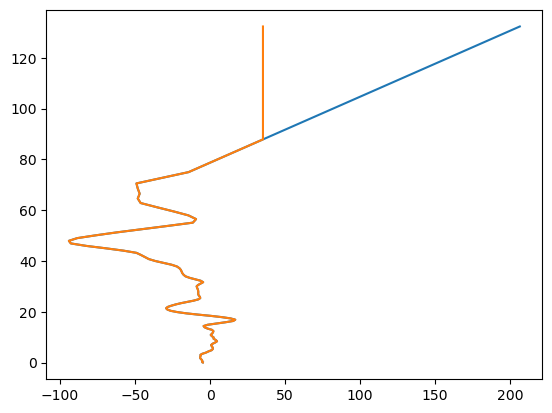

In [6]:
lev_a=eraX.lev.values
zlev_a=-7.0*np.log( lev_a/1_000. )
plt.plot( eraX_copy.U[0,:,20_000],zlev_a)
plt.plot( eraX.U[0,:,20_000],zlev_a)


In [7]:
print('lev' in RestX.SO2.dims)

True


In [8]:
import RegridField as RgF
import copy
importlib.reload( RgF )

eraX_xtnd = copy.deepcopy( eraX )
ps     = eraX.PS.values

for fld in RestXvars:
    Q1 = (('lev' in RestX[fld].dims) or ('ilev' in RestX[fld].dims) )
    Q2 = (fld not in eraXvars )
    #print( fld, Q1, Q2 )
    if ( (Q1==True ) and ( Q2==True) ):
        #print( fld, RestX[fld].dims )
        aa = RestX[fld].values
        aa_z = RgF.Vert(DstVgrid='L135', DstTZHkey='tzc', SrcVgrid='L135', xfld_Src=aa, ps_Src=ps )
        print( fld, RestX[fld].attrs , np.shape(aa_z) )

        
        Dar = xr.DataArray( data=aa_z, 
                            dims=('time','lev','ncol',),
                            attrs=RestX[fld].attrs ,)
        
        eraX_xtnd[fld] = Dar
                


Using Flexible parallel/serial VertRegrid 
 a path added in VertRegridFlexLL /glade/work/juliob/PyRegridding/Regridder/../Utils 
 MyConstants in /glade/work/juliob/PyRegridding/Utils 
 No need to interpolate in the vertical 
AOA1 {'mdims': 1, 'units': 'kg/kg', 'mixing_ratio': 'wet', 'long_name': 'Age-of_air tracer 1', 'cell_methods': 'time: point'} (1, 135, 48602)
 No need to interpolate in the vertical 
AOA2 {'mdims': 1, 'units': 'kg/kg', 'mixing_ratio': 'wet', 'long_name': 'Age-of_air tracer 2', 'cell_methods': 'time: point'} (1, 135, 48602)
 No need to interpolate in the vertical 
CFC11 {'mdims': 1, 'units': 'kg/kg', 'mixing_ratio': 'dry', 'long_name': 'CFC11', 'cell_methods': 'time: point'} (1, 135, 48602)
 No need to interpolate in the vertical 
CFC12 {'mdims': 1, 'units': 'kg/kg', 'mixing_ratio': 'dry', 'long_name': 'CFC12', 'cell_methods': 'time: point'} (1, 135, 48602)
 No need to interpolate in the vertical 
CH4 {'mdims': 1, 'units': 'kg/kg', 'mixing_ratio': 'dry', 'long_name'

In [11]:
# Make destination file name by replacing '_WO.'

#eraF  ='/glade/campaign/cgd/amp/juliob/ERA5/ne30np4/L32/ERA5_x_ne30np4_L32_rgC2_WO.2000-01-01-00000.nc'

eraF_xtnd = eraF.replace('_WO.', '_WO_aero.' )
print(eraF_xtnd)
eraX_xtnd.to_netcdf(  eraF_xtnd )

/glade/campaign/cgd/amp/juliob/ERA5/ne30np4/L135/ERA5_x_ne30np4_L135_rgC2_WO_aero.1985-01-01-00000.nc


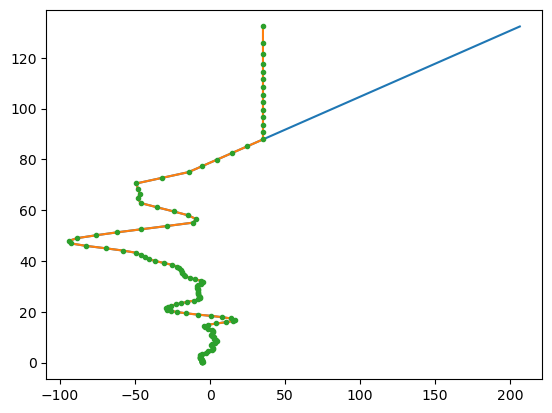

In [10]:
lev_a=eraX.lev.values
zlev_a=-7.0*np.log( lev_a/1_000. )
plt.plot( eraX_copy.U[0,:,20_000],zlev_a)
plt.plot( eraX.U[0,:,20_000],zlev_a)
plt.plot( eraX_xtnd.U[0,:,20_000],zlev_a,'.')


In [ ]:
eraX_xtnd